In [1]:
import torch
import torchvision

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

In [3]:
def get_dataloaders(batch_size=32, num_workers=4):
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])

    full_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    test = datasets.CIFAR10('./data', train=False, transform=transform)

    val_size = int(len(full_train) * 0.1)
    train_size = len(full_train) - val_size
    train, val = random_split(full_train, [train_size, val_size])

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return train_loader, val_loader, test_loader

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34, ResNet34_Weights

In [5]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # gradient clipping
        optimizer.step()

        current_sample = len(data)
        total_sample = len(train_loader.dataset)
        total_batch = len(train_loader)
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * current_sample, total_sample,
                100. * batch_idx / total_batch, loss.item()))
            if args.dry_run:
                break

    return total_loss / total_batch

In [6]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_test_sample = len(test_loader.dataset)

    test_loss /= total_test_sample
    accuracy = 100. * correct / total_test_sample

    print('\nAverage loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss, accuracy))

    return accuracy

In [7]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = Model()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 170MB/s]


In [8]:
import argparse
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [9]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Practice')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=12, metavar='N',
                    help='number of epochs to train (default: 12)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-accel', action='store_true',
                    help='disables accelerator')
parser.add_argument('--dry-run', action='store_true',
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true',
                    help='For Saving the current Model')

args = parser.parse_args(args=[])

torch.manual_seed(args.seed)

In [10]:
use_cuda = not args.no_accel and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
train_loader, val_loader, test_loader = get_dataloaders(batch_size=args.batch_size, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 41.4MB/s]


In [12]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=args.gamma)

In [13]:
train_losses = []
val_accuracies = []

print("=== Train accuracy ===")
for epoch in range(1, args.epochs + 1):
        loss = train(args, model, device, train_loader, optimizer, epoch)
        val_accuracy = test(model, device, val_loader)
        train_losses.append(loss)
        val_accuracies.append(val_accuracy)
        scheduler.step()

print("===Test accuracy===")
test_accuracy = test(model, device, test_loader)

=== Train accuracy ===
Train Epoch: 1 [0/45000 (0%)]	Loss: 2.521135
Train Epoch: 1 [640/45000 (1%)]	Loss: 2.434291
Train Epoch: 1 [1280/45000 (3%)]	Loss: 2.454998
Train Epoch: 1 [1920/45000 (4%)]	Loss: 2.435674
Train Epoch: 1 [2560/45000 (6%)]	Loss: 2.456875
Train Epoch: 1 [3200/45000 (7%)]	Loss: 2.501865
Train Epoch: 1 [3840/45000 (9%)]	Loss: 2.353548
Train Epoch: 1 [4480/45000 (10%)]	Loss: 2.340491
Train Epoch: 1 [5120/45000 (11%)]	Loss: 2.317053
Train Epoch: 1 [5760/45000 (13%)]	Loss: 2.300558
Train Epoch: 1 [6400/45000 (14%)]	Loss: 2.265918
Train Epoch: 1 [7040/45000 (16%)]	Loss: 2.278549
Train Epoch: 1 [7680/45000 (17%)]	Loss: 2.269905
Train Epoch: 1 [8320/45000 (18%)]	Loss: 2.262424
Train Epoch: 1 [8960/45000 (20%)]	Loss: 2.271469
Train Epoch: 1 [9600/45000 (21%)]	Loss: 2.219541
Train Epoch: 1 [10240/45000 (23%)]	Loss: 2.240425
Train Epoch: 1 [10880/45000 (24%)]	Loss: 2.127544
Train Epoch: 1 [11520/45000 (26%)]	Loss: 2.165082
Train Epoch: 1 [12160/45000 (27%)]	Loss: 2.068486
Trai

In [14]:
import matplotlib.pyplot as plt

In [15]:
epochs = list(range(1, args.epochs+1))
test_accuracy_list = [test_accuracy] * len(epochs)

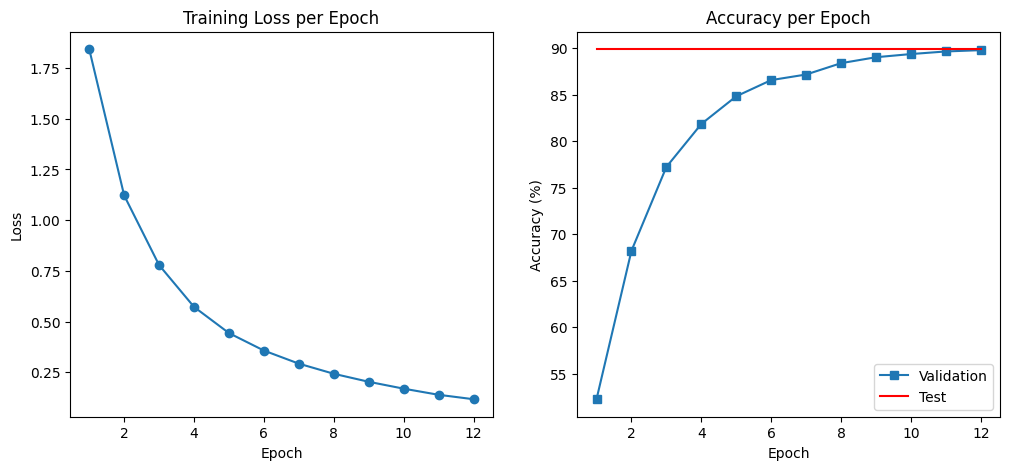

In [17]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='s')
plt.plot(epochs, test_accuracy_list, 'r-')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(['Validation', 'Test'])

plt.show()